In [9]:
import os
os.environ["OPENBLAS_NUM_THREADS"] = "16"
os.environ["NUM_THREADS"] = "16"
os.environ["OMP_NUM_THREADS"] = "16"
from keras.layers import Input, Dense, Flatten, Reshape
from sklearn.feature_extraction import image as sk_image
from concurrent.futures import ProcessPoolExecutor
import cartopy.feature as cfeature
from keras.models import Model
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from sklearn.cluster import AgglomerativeClustering
from scipy.signal import convolve2d 
from scipy import ndimage
from sklearn.cluster import KMeans
import numpy as np
import tensorflow as tf
from tensorflow import keras    
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from sklearn.cluster import DBSCAN
from pyhdf.SD import SD, SDC
import matplotlib as mpl
#tf.config.threading.set_inter_op_parallelism_threads(1)
from extract_training_data import *
from sklearn.feature_extraction.image import extract_patches_2d, reconstruct_from_patches_2d
from pyhdf.error import HDF4Error
from functions import *
from tensorflow.keras.models import load_model
from sklearn.cluster import KMeans, MiniBatchKMeans
import joblib
import plot_functions
import importlib 
importlib.reload(plot_functions)
from plot_functions import *
from sklearn.model_selection import train_test_split
from keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import EarlyStopping
from calculate_scores import *
import matplotlib.path as mpath
import matplotlib.patches as mpatches
# Visualize the result
import matplotlib
import matplotlib.lines as mlines
from skimage import measure

import json
matplotlib.rcParams.update({'font.size': 16})
import functions
importlib.reload(functions)
from functions import * 



# Visualize the result
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,"  , len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)


#bands = [6, 7, 20, 28, 28, 31]
bands=[29]
#bands=[1]
max_vals = np.load("/uio/hume/student-u37/fslippe/data/models/patch_size128/max_val_dnb_l95_z50_ps128_band29_2018-2023.npy")
min_vals = np.load("/uio/hume/student-u37/fslippe/data/models/patch_size128/min_val_dnb_l95_z50_ps128_band29_2018-2023.npy")
merra_folder = "/uio/hume/student-u37/fslippe/MERRA/"

1 Physical GPUs, 1 Logical GPUs
1 Physical GPUs, 1 Logical GPUs


In [4]:
### EXTRACT CAO AND NOn CAO CASES
import importlib
import extract_training_data
importlib.reload(extract_training_data)
from extract_training_data import *
patch_size = 128

start = "20190101"
end = "20190130"
dates = generate_date_list(start, end)
# start = "20191001"
# end = "20191231"
# dates.extend(generate_date_list(start, end))

bands = [29]
folder = "/scratch/fslippe/modis/MOD02_npy/2019/ /scratch/fslippe/modis/MOD02_npy/2020/ /scratch/fslippe/modis/MOD02_npy/2021/ /scratch/fslippe/modis/MOD02_npy/2022/ /scratch/fslippe/modis/MOD02_npy/2023/"
x_cao, dates_cao, masks_cao, lon_lats_cao, mod_min_cao = extract_1km_data(folder,
                                                         bands=bands,
                                                         date_list=dates,
                                                         return_lon_lat=True,
                                                         data_loc=data_loc,
                                                         data_type="npy",
                                                         combine_pics=True)


x_cao, dates_cao, masks_cao, lon_lats_cao, mod_min_cao = zip(*[(xi, date, mask, lon_lat, mod_min) for xi, date, mask, lon_lat, mod_min in zip(x_cao, dates_cao, masks_cao, lon_lats_cao, mod_min_cao) if (xi.shape[0] > patch_size) and (xi.shape[1] > patch_size)])
x_cao = list(x_cao)
dates_cao = list(dates_cao)
len(x_cao)

total cores: 256
['/scratch/fslippe/modis/MOD02_npy/2019/', '/scratch/fslippe/modis/MOD02_npy/2020/', '/scratch/fslippe/modis/MOD02_npy/2021/', '/scratch/fslippe/modis/MOD02_npy/2022/', '/scratch/fslippe/modis/MOD02_npy/2023/']
2019001   1855
2019001   45
2019001   1900
2019001   50
2019001   2030
2019001   230
2019001   2035
2019001   410
2019001   2040
2019001   550
2019001   2210
2019001   725
2019001   2350
2019001   730
2019001   2215
2019001   735
2019001   2355
2019001   905
2019002   130
2019001   910
2019002   135
2019001   915
2019002   315
2019001   1045
2019002   450
2019001   1050
2019002   455
2019001   1055
2019002   630
2019001   1225
2019002   635
2019001   1230
2019002   820
2019001   1400
2019002   950
2019001   1405
2019002   955
2019001   1410
2019002   1000
2019001   1540
2019002   1130
2019001   1545
2019002   1135
2019001   1715
2019002   1305
2019001   1720
2019002   1310
2019001   1850
2019002   810
2019002   1315
2019002   815
2019016   1815
2019002   1445
20

100%|██████████| 30/30 [01:10<00:00,  2.36s/it]


358
358


308

In [7]:
gc.collect()
autoencoder_predict = SimpleAutoencoder(len(bands), patch_size, patch_size)

patches, all_lon_patches, all_lat_patches, starts, ends, shapes, n_patches_tot, indices = generate_patches([xi[:,:,0] for xi in x_cao],
                                                                                                            masks_cao,
                                                                                                            lon_lats_cao,
                                                                                                            max_vals,
                                                                                                            min_vals,
                                                                                                            autoencoder_predict,
                                                                                                            strides=[1, patch_size, patch_size,1])
n_patches = len(patches)

In [12]:
last_filter = 64
with tf.device('/CPU:0'):   
    encoded_patches_flat_cao = load_and_predict_encoder(patch_size, last_filter, patches)

In [14]:
n_K = 12
labels, global_min, global_max = get_cluster_results(encoded_patches_flat_cao, patch_size, last_filter, n_K)
del encoded_patches_flat_cao 
gc.collect()
open_label = np.load(f"/uio/hume/student-u37/fslippe/data/models/patch_size{patch_size}/filter{last_filter}/clustering/cluster_dnb_l95_z50_ps{patch_size}_band29_filter{last_filter}_K{n_K}_opencell_label.npy")
closed_label = np.load(f"/uio/hume/student-u37/fslippe/data/models/patch_size{patch_size}/filter{last_filter}/clustering/cluster_dnb_l95_z50_ps{patch_size}_band29_filter{last_filter}_K{n_K}_closedcell_label.npy")
    
# label_map, lon_map, lat_map = process_label_maps(labels,
#                                                 all_lon_patches_cao,
#                                                 all_lat_patches_cao,
#                                                 starts_cao,                 
#                                                 ends_cao,
#                                                 shapes_cao,         
#                                                 indices_cao,
#                                                 global_max,             
#                                                 n_patches_tot_cao,              
#                                                 patch_size,
#                                                 strides,
#                                                 closed_label, 
#                                                 open_label, 
#                                                 size_thr_1=size_threshold, 
#                                                 size_thr_2=size_threshold)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/opt/software/easybuild/software/TensorFlow/2.7.1-foss-2021b-CUDA-11.4.1/lib/python3.9/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2838, in while_loop
    return result  File "/opt/software/easybuild/software/TensorFlow/2.7.1-foss-2021b-CUDA-11.4.1/lib/python3.9/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2786, in <lambda>
    body = lambda i, lv: (i + 1, orig_body(*lv))  File "/opt/software/easybuild/software/TensorFlow/2.7.1-foss-2021b-CUDA-11.4.1/lib/python3.9/site-packages/tensorflow/python/ops/map_fn.py", line 497, in compute
    return (i + 1, tas)  File "/opt/software/easybuild/software/TensorFlow/2.7.1-foss-2021b-CUDA-11.4.1/lib/python3.9/site-packages/tensorflow/python/ops/map_fn.py", line 495, in <

9866

In [22]:
projection = ccrs.Stereographic(central_latitude=90)
target_months = [1]#[1, 2, 3, 4, 10, 11, 12]
import functions
importlib.reload(functions)
from functions import * 
size_thresholds = [30]#[3,4,5,6,7]
desired_label = [open_label, closed_label]
grid_resolution = 128e3
year = dates_cao[0][:4]
for size_threshold in size_thresholds:
    for target_month in target_months:
        print("/uio/hume/student-u37/fslippe/data/hist_maps/%s/hist_counts_res%s_thr%s_ps%s_filters%s_%s%s" %(year, int(grid_resolution*1e-3), size_threshold, patch_size, last_filter, year, str(target_month).zfill(2)))
        idx = np.array([i for i, date_str in enumerate(dates_cao) if datetime.datetime.strptime(date_str, '%Y%j').month == target_month])
        x_grid, y_grid, counts = generate_hist_map(
                                    [n_patches_tot[i] for i in idx],
                                    [indices[i] for i in idx],
                                    labels,
                                    [starts[i] for i in idx],
                                    [ends[i] for i in idx],  
                                    [shapes[i] for i in idx],
                                    [all_lon_patches[i] for i in idx],
                                    [all_lat_patches[i] for i in idx],
                                    [dates_cao[i] for i in idx],
                                    desired_label=desired_label,
                                    size_threshold=size_threshold,
                                    patch_size=patch_size,
                                    global_max=n_K,
                                    projection=projection,
                                    grid_resolution=grid_resolution)
        tot_days = len(set(np.array(dates_cao)[idx]))
        ds = {"days": tot_days, "counts": counts}
        np.save("/uio/hume/student-u37/fslippe/data/hist_maps/%s/hist_counts_res%s_thr%s_ps%s_filters%s_nK%s_%s%s" %(year, int(grid_resolution*1e-3), size_threshold, patch_size, last_filter, n_K, year, str(target_month).zfill(2)), ds)



/uio/hume/student-u37/fslippe/data/hist_maps/2019/hist_counts_res128_thr30_ps128_filters64_201901


In [25]:
"/uio/hume/student-u37/fslippe/data/hist_maps/%s/hist_counts_res%s_thr%s_ps%s_filters%s_nK%s_%s%s" %(year, int(grid_resolution*1e-3), size_threshold, patch_size, last_filter, n_K, year, str(target_month).zfill(2))

'/uio/hume/student-u37/fslippe/data/hist_maps/2019/hist_counts_res128_thr30_ps128_filters64_nK12_201901'

/uio/hume/student-u37/fslippe/.local/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1655: UserWarning: The following kwargs were not used by contour: 'set_under'
  result = super().contourf(*args, **kwargs)


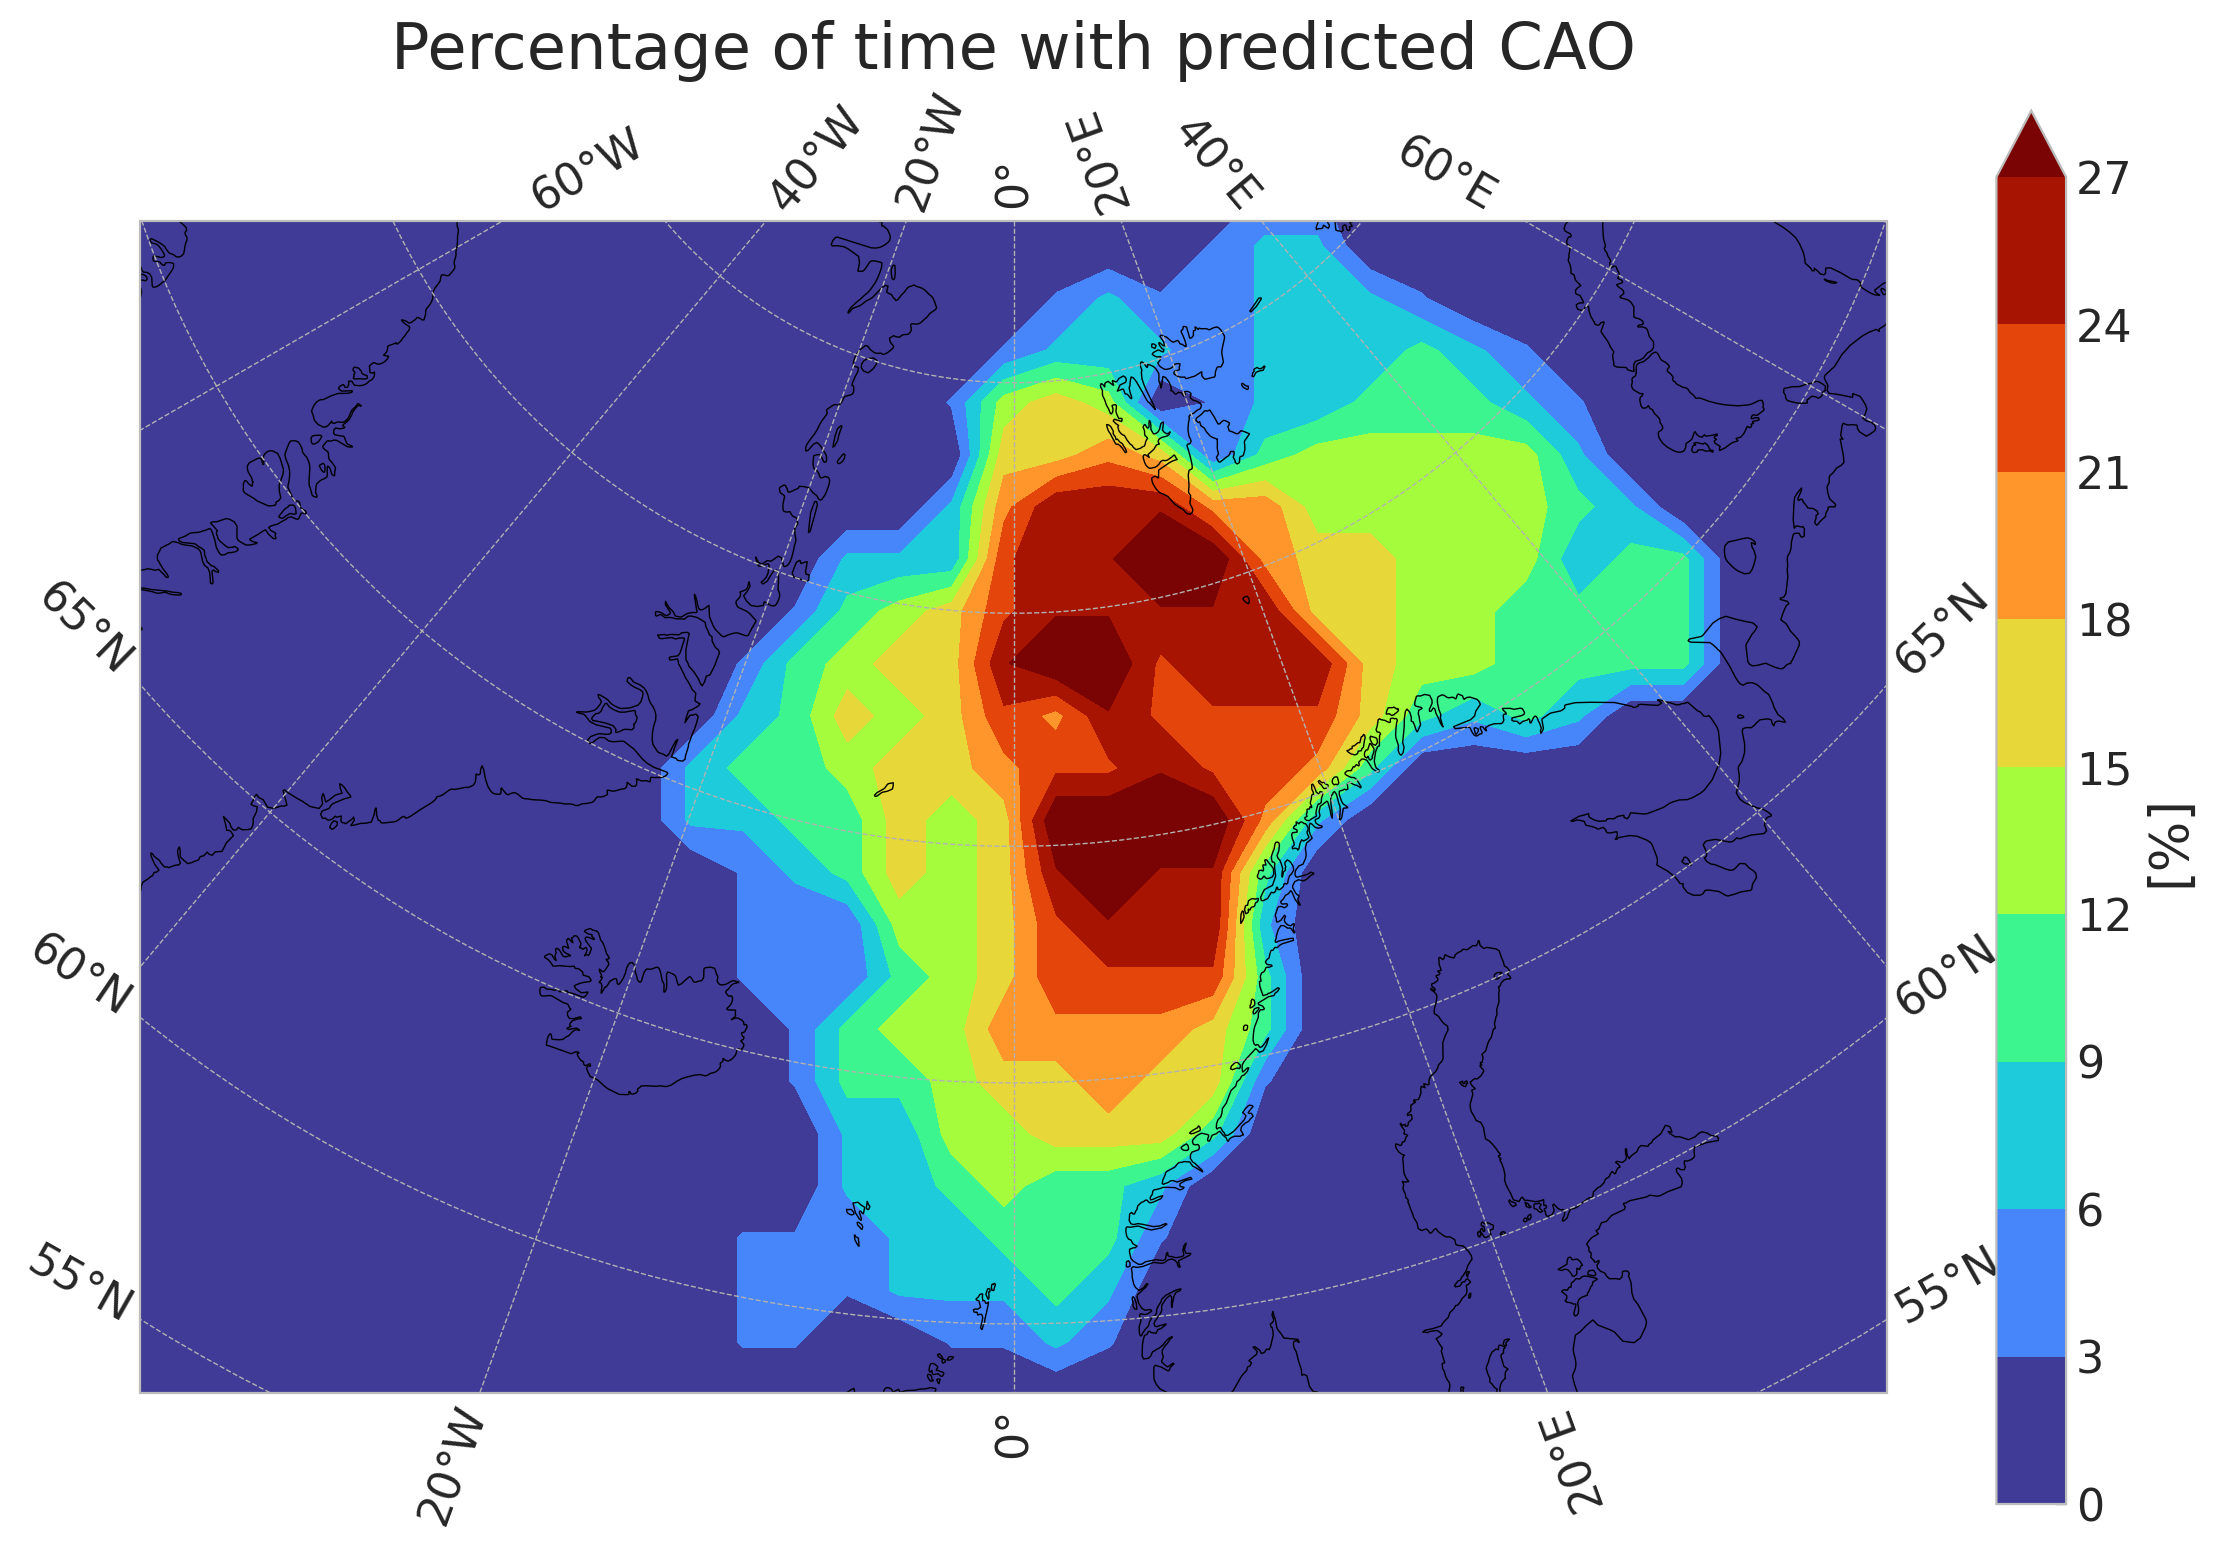

In [23]:
# ds = np.load("/uio/hume/student-u37/fslippe/data/hist_maps/%s/hist_counts_res%s_thr%s_ps%s_filters%s_%s%s.npy" %(year, int(grid_resolution*1e-3), 6, patch_size, filters, year, str(1).zfill(2)), allow_pickle=True).item()
# counts = ds["counts"]
# tot_days = ds["days"]
import plot_functions 
importlib.reload(plot_functions)
from plot_functions import * 
fig, ax = plot_hist_map(x_grid, y_grid, counts, tot_days, projection, title="Percentage of time with predicted CAO", extent=[-36, 36, 58.2, 82], levels=10, cmap="turbo")


In [ ]:
# Visualize the result
import plot_functions
importlib.reload(plot_functions)
from plot_functions import * 
tot_days = len(set(np.array(dates_cao)[idx]))
print(tot_days)
plot_hist_map(x_grid, y_grid, counts, tot_days, projection, title="Percentage of time with predicted CAO", extent=[-36, 36, 58.2, 82], levels=10, cmap="turbo")


31


KeyboardInterrupt: 